In [24]:
import os
from efficientnet_pytorch import EfficientNet
import torch
from torch.utils.data import Dataset, DataLoader # Dataset : to customize own dataset, must have __init__, __len__, __getitem__
                                                 # DataLoader : to set batch size, shuffle and stuff
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage, RandomHorizontalFlip, RandomRotation, CenterCrop
from torchvision import models
from PIL import Image
import pandas as pd

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Data prep

In [26]:
class wbc_dataset(Dataset): # have Dataset in to tell this class is like torch.utils.data.Dataset, but I will customize it to suit my needs
    def __init__(self, image_dir, transform=None, csv_file=None):
        self.image_dir = image_dir
        self.transform = transform # set transforms to do resize, ToTensor and stuff
        self.images = []
        self.labels = []

        # If a CSV file i provided for valid set, load the file and labels from it
        if csv_file:
            data = pd.read_csv(csv_file)
            self.images = [os.path.join(self.image_dir, row['new_names']) for _, row in data.iterrows()]
            self.labels = data['labels'].tolist()
        else:
        #Load images from all_images folder and assign label 1
            all_dir = os.path.join(image_dir, "all_images")
            for filename in os.listdir(all_dir):
                self.images.append(os.path.join(all_dir, filename))
                self.labels.append(1)
                
            #Load images from all_images folder and assign label 0
            hem_dir = os.path.join(image_dir, "hem_images")
            for filename in os.listdir(hem_dir):
                self.images.append(os.path.join(hem_dir, filename))
                self.labels.append(0)
    
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

Length of dataset : 10661
Label: 1


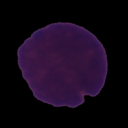

torch.Size([3, 128, 128])
Label: 0


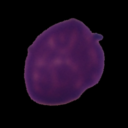

torch.Size([3, 128, 128])
Label: 0


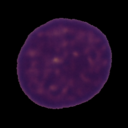

torch.Size([3, 128, 128])


In [27]:
# Paths
train_image_dir = '/home/kwan/ALL_classification/training_data/'
valid_image_dir = '/home/kwan/ALL_classification/validation_data/C-NMC_test_prelim_phase_data'
valid_csv_file = '/home/kwan/ALL_classification/validation_data/C-NMC_test_prelim_phase_data_labels.csv'

#define transform (ToTensor)
transform = Compose([RandomHorizontalFlip(),
                    RandomRotation(45),
                    CenterCrop(270),
                    Resize(128),
                    ToTensor()
                    ])

# Train and Validation Datasets
train_dataset = wbc_dataset(image_dir=train_image_dir, transform=transform)
valid_dataset = wbc_dataset(image_dir=valid_image_dir, transform=transform, csv_file=valid_csv_file)

print(f"Length of dataset : {len(train_dataset)}")

# Display someimages
to_pil = ToPILImage()
for i in range(3):
    image, label = train_dataset[-i]
    print(f'Label: {label}')

    pil_image = to_pil(image)
    display(pil_image)
    
    print(image.size())

### Data loaders

In [28]:
# Dataloaders
loaders = {
    'train': DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=1),
    'valid': DataLoader(valid_dataset, batch_size=50, shuffle=False, num_workers=1),
}

# Models

### Custom CNN model

In [29]:
# Custom CNN Model
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.3))
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.4))
        
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256 * 4 * 4, 512), # Adjusting based on input image size
            torch.nn.ReLU(),
            torch.nn.Dropout(0.6),
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_cnn = CNN().to(device)

In [30]:
# Loss function and optimizer
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0001, weight_decay=0.0001)

training_epochs = 7

for epoch in range(training_epochs):
    model_cnn.train()
    avg_cost = 0

    for X, Y in loaders['train']:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        pred = model_cnn(X)
        pred = pred.squeeze(1)
        cost = loss_func(pred, Y.float())
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()

    print(f'[Epoch: {epoch+1}] cost = {avg_cost / len(loaders["train"]):.6f}')

    # Validation phase
    model_cnn.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_val, Y_val in loaders['valid']:
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)

            pred_val = model_cnn(X_val)
            pred_val = pred_val.squeeze(1)
            val_loss += loss_func(pred_val, Y_val.float()).item()

            # For binary classification, calculate accuracy
            predicted = (pred_val > 0.5).float()  # Threshold at 0.5
            correct += (predicted == Y_val).sum().item()
            total += Y_val.size(0)

    val_loss = val_loss / len(loaders['valid'])  # Average validation loss
    val_accuracy = correct / total  # Accuracy
    print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2%}')

[Epoch: 1] cost = 0.489635
Validation Loss: 0.616501, Validation Accuracy: 70.65%
[Epoch: 2] cost = 0.440287
Validation Loss: 0.644403, Validation Accuracy: 70.38%
[Epoch: 3] cost = 0.399904
Validation Loss: 0.673948, Validation Accuracy: 70.65%
[Epoch: 4] cost = 0.363374
Validation Loss: 0.633498, Validation Accuracy: 70.76%
[Epoch: 5] cost = 0.345629
Validation Loss: 0.734068, Validation Accuracy: 71.72%
[Epoch: 6] cost = 0.329012
Validation Loss: 0.540103, Validation Accuracy: 73.54%
[Epoch: 7] cost = 0.311889
Validation Loss: 0.768106, Validation Accuracy: 69.58%


### EfficientNet model

In [18]:
class EfficientNetBinaryClassifier(torch.nn.Module):
    def __init__(self):
        super(EfficientNetBinaryClassifier, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b3')
        self.base_model._fc = torch.nn.Sequential(
            torch.nn.Linear(self.base_model._fc.in_features, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        return self.base_model(x)

model_effNet = EfficientNetBinaryClassifier().to(device)

Loaded pretrained weights for efficientnet-b3


In [19]:
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_effNet.parameters(), lr=0.0001)

training_epochs = 7

for epoch in range(training_epochs):
    # training phase
    model_effNet.train()
    avg_cost = 0

    for X, Y in loaders['train']:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        pred = model_effNet(X)
        pred = pred.squeeze(1)
        cost = loss_func(pred, Y.float())
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()    
    
    print(f'[Epoch: {epoch+1}] cost = {avg_cost/len(loaders["train"]):.6f}')

    # validation phase
    model_effNet.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for X_val, Y_val in loaders['valid']:
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)

            pred_val = model_effNet(X_val)
            pred_val = pred_val.squeeze(1)
            val_loss += loss_func(pred_val, Y_val.float()).item()

            # For binary classification, calculate accuracy
            predicted = (pred_val > 0.5).float()  # Threshold at 0.5
            correct += (predicted == Y_val).sum().item()
            total += Y_val.size(0)

    val_loss = val_loss / len(loaders['valid'])  # Average validation loss
    val_accuracy = correct / total  # Accuracy
    print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2%}')

[Epoch: 1] cost = 0.359116
Validation Loss: 0.866464, Validation Accuracy: 65.77%
[Epoch: 2] cost = 0.225740
Validation Loss: 0.998514, Validation Accuracy: 66.52%
[Epoch: 3] cost = 0.174082
Validation Loss: 0.603912, Validation Accuracy: 78.63%
[Epoch: 4] cost = 0.140538
Validation Loss: 0.572077, Validation Accuracy: 78.47%
[Epoch: 5] cost = 0.117135
Validation Loss: 0.520349, Validation Accuracy: 78.95%
[Epoch: 6] cost = 0.095449
Validation Loss: 0.549321, Validation Accuracy: 80.99%
[Epoch: 7] cost = 0.084871
Validation Loss: 0.696530, Validation Accuracy: 77.45%
